In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))

# from caiman.utils.utils import load_dict_from_hdf5
from matplotlib import pyplot as plt


## Prepare & display data

40


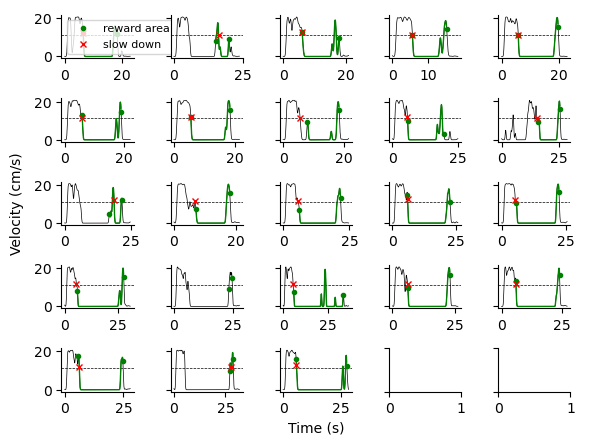

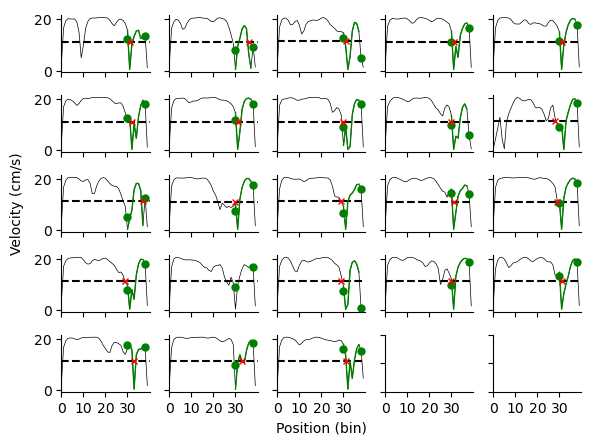

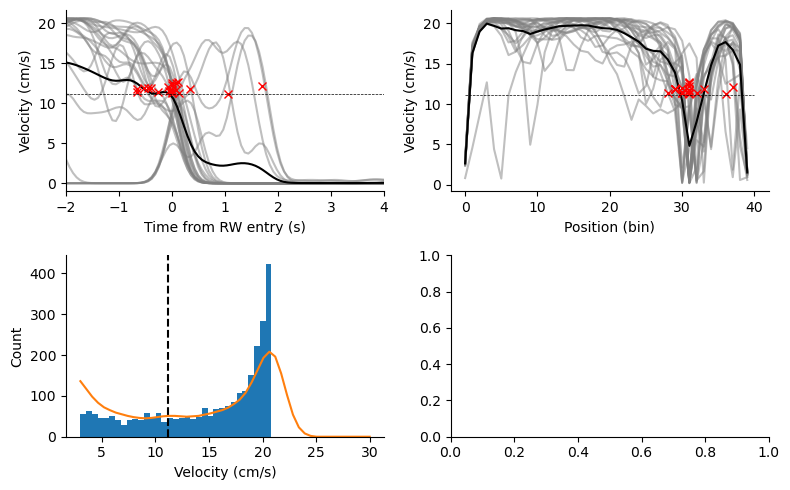

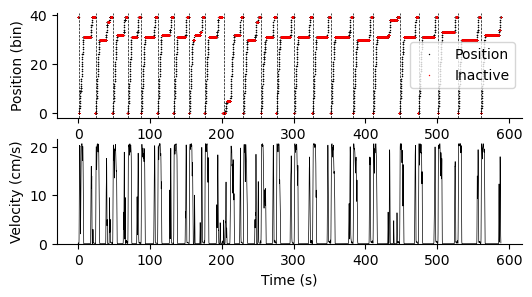

In [2]:
from placefield_detection.utils import prepare_behavior_from_file, plot_behavior

pathMouse = Path("../../../../data/845ad")
pathSession = pathMouse / "Session40"
f = 15.0
nbin = 40
only_active = True

pathBehavior = pathSession / "aligned_behavior.pkl"
behavior = prepare_behavior_from_file(
    pathBehavior,
    only_active=only_active,
    environment_length=120.0,
    nbin=nbin,
    f=15.0,
    T=None,
    calculate_performance=True,
    plt_bool=True,
    plt_trials=True,
)


plot_behavior(behavior)

In [3]:
from caiman.utils.utils import load_dict_from_hdf5
from placefield_detection.utils import prepare_activity, plot_activity

pathActivity = [
    file
    for file in pathSession.iterdir()
    if (
        file.stem.startswith("results_CaImAn")
        and not "compare" in file.stem
        and "redetected" in file.stem
    )
][0]

ld = load_dict_from_hdf5(pathActivity)

# neuron_activity = prepare_activity(
#     ld["S"][0, :],
#     behavior,
#     f=f,
#     only_active=only_active,
# )

/home/wollex/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-01 21:48:09.306152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759348089.321871   30148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759348089.327038   30148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


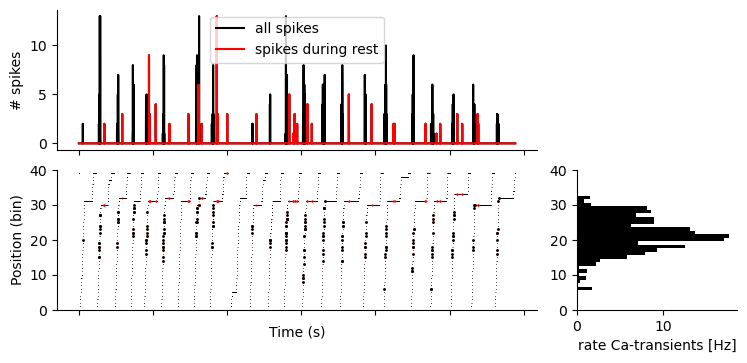

In [4]:
n = 11
neuron_activity = ld["S"].copy()
activity = prepare_activity(neuron_activity[n, :], behavior, f=15.0, only_active=True)

# from placefield_detection.alternative_detection_methods import (
#     peak_method_batch,
#     information_method_batch,
#     stability_method

plot_activity(activity, behavior, f=f)

## Test Bayes Hierarchical Method

In [82]:
import numpy as np
from placefield_detection.BayesModel import HierarchicalBayesInference
from placefield_detection.HierarchicalBayesModel import (
    parse_name_and_indices,
)
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)
from placefield_detection.result_structures import PlaceFieldInferenceResults

mode = "dynesty"
vectorized = mode=="ultranest"
# vectorized = False

HBI = HierarchicalBayesInference(logLevel="ERROR")
HBI.prepare_data(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    iter_dims=False,
    dimension_names=["trials", "position_bins"],
)
HBI.set_priors(N_f=1)
for key in HBI.priors.keys():
    param_name, indices = parse_name_and_indices(key,["field",""])
    print(f"{key:20s}, {param_name:15s}, {indices}")



# print(HBI.parameter_names_all)

"""
* make build results independent of HBI
* ensure param_names_all is replaced properly: in build_posterior, store_functions, etc
* ensure periodic is passed properly
* store x_arrays as 3-value tuple, instead of array (construct from scratch)
"""
# print(f"N_f:",res.N_f)
# print(res.fields["active_trials"].shape)

results = []
for n_field in range(3):

    HBI.set_priors(N_f=n_field)

    my_prior_transform = HBI.set_prior_transform(vectorized=vectorized)
    my_likelihood = HBI.set_logp_func(vectorized=vectorized)

    tmp_results, sampler = run_sampling(
        my_prior_transform,
        my_likelihood,
        HBI.parameter_names_all,
        nP=12,
        n_live=100, periodic=HBI.periodic,
        mode=mode
    )
    results.append(tmp_results)

A0                  , A0             , [None, None]
A_field0            , A              , [0, None]
sigma_field0        , sigma          , [0, None]
theta_field0_mean   , theta_mean     , [0, None]
theta_field0_sigma  , theta_sigma    , [0, None]
theta_field0        , theta          , [0, None]
running nested sampling


3611it [00:31, 114.20it/s, +100 | bound: 72 | nc: 1 | ncall: 74069 | eff(%):  5.017 | loglstar:   -inf < -2161.522 <    inf | logz: -2197.873 +/-  0.560 | dlogz:  0.010 >  1.000]


running nested sampling


4166it [00:46, 89.50it/s, +100 | bound: 84 | nc: 1 | ncall: 667455 | eff(%):  0.639 | loglstar:   -inf < -956.398 <    inf | logz: -998.171 +/-  0.689 | dlogz:  0.014 >  1.000]


running nested sampling


5233it [03:01, 28.86it/s, +100 | bound: 118 | nc: 1 | ncall: 1641110 | eff(%):  0.325 | loglstar:   -inf < -970.554 <    inf | logz: -1022.833 +/-  0.750 | dlogz:  0.012 >  1.000]


In [83]:
res = PlaceFieldInferenceResults(n_bin=HBI.n_bin, n_trials=HBI.n_samples, modes=["bayesian"])

n_field = 2
HBI.set_priors(N_f=n_field)
res.build_results(HBI.priors)

# print(res.periodic)
res.store_inference_results(results[n_field],HBI.parameter_names_all, periodic=HBI.periodic, logp=HBI.set_logp_func(vectorized=False))
res.fields

{'n_modes': array(2),
 'parameter': {'global': {'A0': array([0.07826828, 0.02811796, 0.12061489]),
   'A': array([[2.76713529e-02, 2.00650748e-03, 7.89626777e-02],
          [2.00919953e+01, 1.84612588e+01, 2.17347146e+01]]),
   'sigma': array([[2.10340458, 1.08416444, 3.29972835],
          [3.92501291, 3.76526792, 4.10199922]]),
   'theta_mean': array([[ 2.16209819,  0.55881667,  3.8741335 ],
          [20.80576423, 19.99567802, 21.6461243 ]]),
   'theta_sigma': array([[0.72902669, 0.08225354, 1.57766087],
          [3.22880462, 2.60467523, 4.17274358]]),
   'theta': array([[ 2.16209819,  0.55881667,  3.8741335 ],
          [20.80576423, 19.99567802, 21.6461243 ]])},
  'local': {'theta': array([[[ 2.6009268 ,  0.55688683,  4.80293961],
           [ 2.10258128,  0.49296971,  4.06153237],
           [ 1.54578685,  0.25491411,  3.13020666],
           [ 1.92079706,  0.35680581,  4.01343286],
           [ 1.98719002,  0.37590482,  3.91203731],
           [ 1.98039695,  0.34226417,  4.152

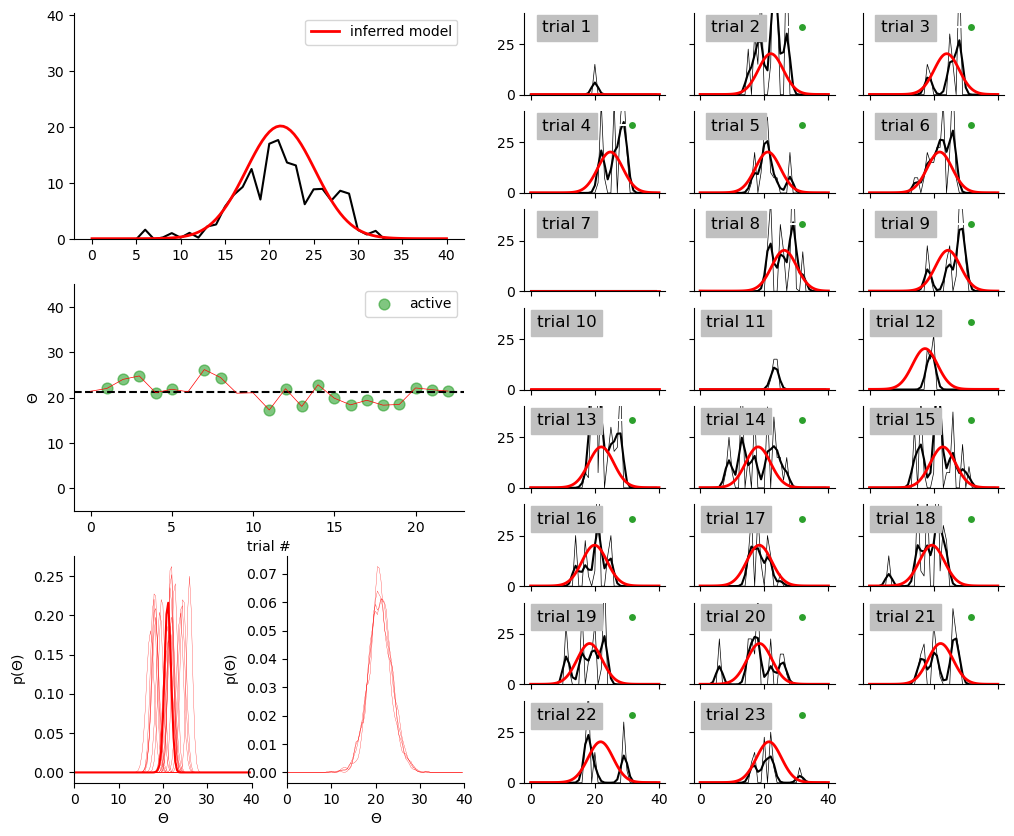

'\n* write logic to automatically assign "winning model"\n* write logic to assing firingstats, etc\n* incorporate in "process_session"\n* run on data! \n'

In [97]:
from placefield_detection.result_structures import PlaceFieldInferenceResults, build_results, handover_inference_results, extract_inference_results
# from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import plot_results
from placefield_detection.analyze_results import display_results

n_cells = 1
n = 0
res = PlaceFieldInferenceResults(n_bin=HBI.n_bin, n_trials=HBI.n_samples)

HBI.set_priors(N_f=0)
overall_res = build_results(n_cells=n_cells, n_bin=HBI.n_bin, n_trials=HBI.n_samples, modes=["bayesian","threshold"])

N_f = 2
overall_res["bayesian"]["field_models"]["logz"] = np.zeros((n_cells,) if n_cells>1 else ()+(N_f+1,2))  # n_cells, n_field_models, (logz, logz_err)

n = n if n_cells>1 else None
for n_field in range(3):
    HBI.set_priors(N_f=n_field)
    res.build_results(priors=HBI.priors)
    res.store_inference_results(results[n_field],HBI.parameter_names_all, periodic=HBI.periodic, logp=HBI.set_logp_func(vectorized=False))

    overall_res["bayesian"]["field_models"][n_field] = res.fields
    # handover_inference_results(res.fields, overall_res["bayesian"]["field_models"][n_field], idx=n if n_cells>1 else None)

    # hand over logz to joint results for easier comparison
    overall_res["bayesian"]["field_models"]["logz"][n_field,:] = overall_res["bayesian"]["field_models"][n_field]["logz"]#[n,:]

for key in ["firing_rate","map_rates","map_trial_rates"]:
    overall_res["firingstats"][key][n,...] = activity[key]

## set "winning model"
res.build_results(priors=HBI.priors)

overall_res["bayesian"]["fields"] = res.fields
overall_res["bayesian"]["fields"] = handover_inference_results(overall_res["bayesian"]["field_models"][1], overall_res["bayesian"]["fields"], idx=n if n_cells>1 else None)

# overall_res["bayesian"]["field_models"][1]
# plot_results(HBI, results[n_field], mode="dynesty")

# single_res = extract_inference_results(overall_res,1)
# single_res["bayesian"]["field_models"][1]
display_results(overall_res,n)


"""
* write logic to automatically assign "winning model"
* write logic to assing firingstats, etc
* incorporate in "process_session"
* run on data! 
"""

In [98]:
overall_res["bayesian"]["fields"]

{'n_modes': array(1),
 'parameter': {'global': {'A0': array([0.09589206, 0.04568699, 0.15344985]),
   'A': array([[20.14684345, 18.61042447, 21.7568378 ],
          [ 0.        ,  0.        ,  0.        ]]),
   'sigma': array([[3.89227463, 3.70872546, 4.07485375],
          [0.        , 0.        , 0.        ]]),
   'theta_mean': array([[21.27907663, 20.27930083, 22.27405908],
          [ 0.        ,  0.        ,  0.        ]]),
   'theta_sigma': array([[2.71118737, 2.08388816, 3.53578497],
          [0.        , 0.        , 0.        ]]),
   'theta': array([[21.27907663, 20.27930083, 22.27405908],
          [ 0.        ,  0.        ,  0.        ]])},
  'local': {'theta': array([[[21.42529731, 17.27566185, 25.89945303],
           [22.04386283, 21.29981897, 22.75874445],
           [24.05168142, 22.93703133, 25.14810666],
           [24.80981427, 23.9313468 , 25.72032931],
           [21.12604496, 19.9661861 , 22.33283579],
           [21.86947735, 20.96875338, 22.75459871],
          

In [101]:
from placefield_detection.BayesModel import model_comparison

n = 11
neuron_activity = ld["S"].copy()
activity = prepare_activity(neuron_activity[n, :], behavior, f=15.0, only_active=True)

inference_results = model_comparison(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    show_status=True
)



n_field=0

running nested sampling


3761it [00:35, 105.41it/s, +100 | bound: 75 | nc: 1 | ncall: 76429 | eff(%):  5.058 | loglstar:   -inf < -2161.522 <    inf | logz: -2199.389 +/-  0.573 | dlogz:  0.010 >  1.000]



n_field=1

running nested sampling


4131it [00:50, 81.81it/s, +100 | bound: 85 | nc: 1 | ncall: 668258 | eff(%):  0.633 | loglstar:   -inf < -957.178 <    inf | logz: -998.554 +/-  0.686 | dlogz:  0.013 >  1.000]



n_field=2

running nested sampling


4858it [02:51, 28.39it/s, +100 | bound: 103 | nc: 1 | ncall: 1493717 | eff(%):  0.332 | loglstar:   -inf < -967.170 <    inf | logz: -1015.726 +/-  0.724 | dlogz:  0.012 >  1.000]


In [22]:
from placefield_detection.BayesModel import HierarchicalBayesInference

HBI = HierarchicalBayesInference(logLevel="ERROR")
HBI.prepare_data(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    iter_dims=False,
    dimension_names=["trials", "position_bins"],
)
HBI.set_priors(N_f=1)
HBI.parameter_names_all

['A0',
 'A_field0',
 'sigma_field0',
 'theta_field0_mean',
 'theta_field0_sigma',
 'theta_field0_0',
 'theta_field0_1',
 'theta_field0_2',
 'theta_field0_3',
 'theta_field0_4',
 'theta_field0_5',
 'theta_field0_6',
 'theta_field0_7',
 'theta_field0_8',
 'theta_field0_9',
 'theta_field0_10',
 'theta_field0_11',
 'theta_field0_12',
 'theta_field0_13',
 'theta_field0_14',
 'theta_field0_15',
 'theta_field0_16',
 'theta_field0_17',
 'theta_field0_18',
 'theta_field0_19',
 'theta_field0_20',
 'theta_field0_21',
 'theta_field0_22']

In [ ]:
from placefield_detection.process_single_neuron import process_single_neuron
process_neuron = process_single_neuron(
    behavior,
    ["bayesian"],
    ["bayesian"]
)

# process_neuron.run_preprocessing(
#     neuron_activity[n,:],
# )
results = process_neuron.run_detection(neuron_activity[n,:])


n_field=0

running nested sampling


1429it [00:12, 110.83it/s, bound: 25 | nc: 19 | ncall: 27074 | eff(%):  5.278 | loglstar:   -inf < -2440.298 <    inf | logz: -2457.616 +/-  0.400 | dlogz: 102.630 >  1.000]Process ForkPoolWorker-215:


Exception while calling loglikelihood function:

Process ForkPoolWorker-210:
Process ForkPoolWorker-216:
Process ForkPoolWorker-211:
Process ForkPoolWorker-205:
Process ForkPoolWorker-214:
Process ForkPoolWorker-209:
Process ForkPoolWorker-206:
Process ForkPoolWorker-207:


Exception while calling loglikelihood function:

Process ForkPoolWorker-208:



  params:

Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):


  params:

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()


[0.50353292]

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()


  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
Traceback (most recent call last):


[0.56550558]

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  args:

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:


  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^


  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^

  args:

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


[]

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/home/wollex/minifo

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^


  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
KeyboardInterrupt
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
KeyboardInterrupt
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
          ^^^^^^^^^^^^^^^^^^^^^^^^^


[]  kwargs:

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
KeyboardInterrupt
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt
KeyboardInterrupt


  kwargs:

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/connection.py", line 430, in _recv_bytes
    buf = self._recv(4)
          ^^^^^^^^^^^^^


{} 

  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/multiprocessing/connection.py", line 395, in _recv
    chunk = read(handle, remaining)
            ^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt


  exception:{}

  exception:


Traceback (most recent call last):
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/site-packages/dynesty/dynesty.py", line 913, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Traceback (most recent call last):
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/site-packages/dynesty/pool.py", line 38, in loglike_cache
    return FunctionCache.loglike(x, *FunctionCache.logl_args, *args,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wollex/Data/Science/WolfGroup/PlaceFields/Programs/PC_analysis/placefield_dynamics/placefield_detection/BayesModel.py", line 176, in get_logp
    (f"{logp_at_trial_and_position.shape} {logp_at_trial_and_position=}")
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/site-packages/dynesty/dynesty.py", line 913, in __call__


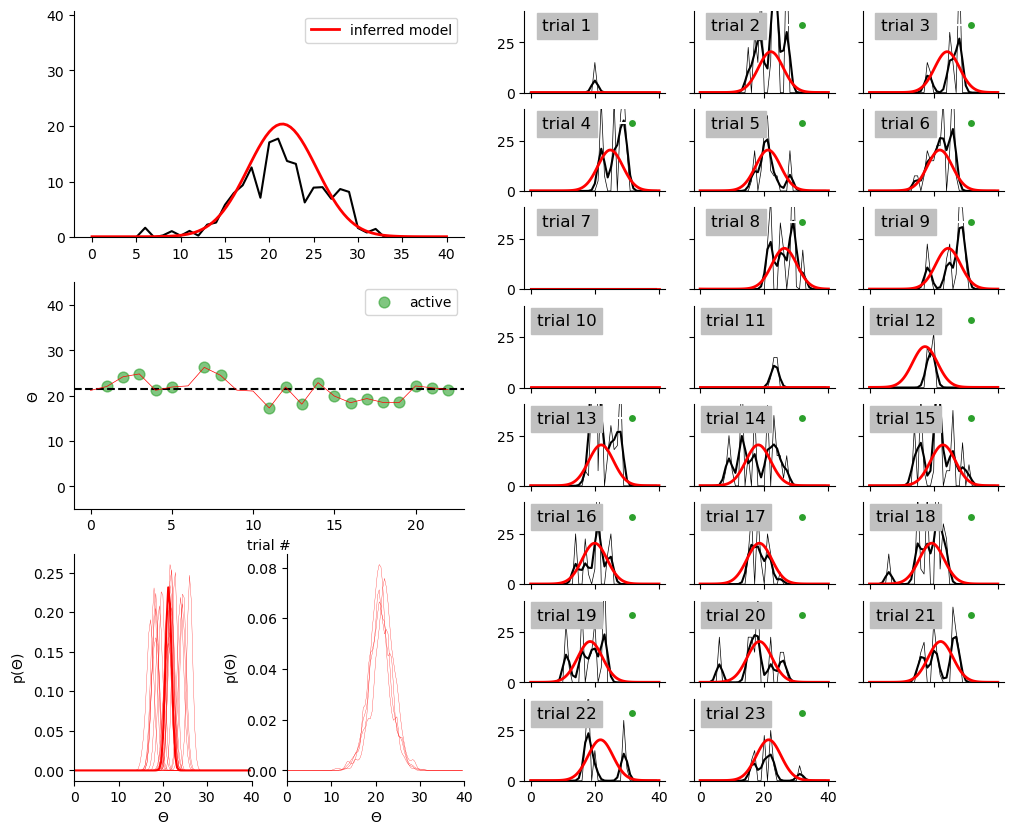

In [102]:
from placefield_detection.analyze_results import display_results

for key in ["firing_rate","map_rates","map_trial_rates"]:
    inference_results["firingstats"][key] = activity[key]
display_results(inference_results)

In [ ]:
HBI = HierarchicalBayesInference(logLevel="ERROR")
HBI.prepare_data(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    iter_dims=False,
    dimension_names=["trials", "position_bins"],
)

array([-4316.01202008])

In [40]:
HBI.set_priors(N_f=0)
my_prior_transform = HBI.set_prior_transform(vectorized=False)
my_likelihood = HBI.set_logp_func(vectorized=False)


p = np.random.rand(HBI.n_params)
p_transformed = my_prior_transform(p)
my_likelihood(p_transformed)

# params = HBI.get_params_from_p(p_transformed)
# build_distr_structure_from_params(params, "field", place_field)

-4421.767528458916

In [43]:
results, sampler = run_sampling(
    my_prior_transform,
    my_likelihood,
    HBI.parameter_names_all,
    nP=12,
    n_live=100, periodic=HBI.periodic,
    mode=mode
)

running nested sampling


3577it [00:28, 123.40it/s, +100 | bound: 71 | nc: 1 | ncall: 72858 | eff(%):  5.054 | loglstar:   -inf < -2161.522 <    inf | logz: -2197.514 +/-  0.556 | dlogz:  0.010 >  1.000]


In [39]:
HBI.dimensions

{'shape': (23, 40), 'n': 2, 'names': ['trials', 'position_bins']}

In [10]:
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)

mode = "dynesty"
vectorized = mode=="ultranest"
my_prior_transform = HBI.set_prior_transform(vectorized=vectorized)
my_likelihood = HBI.set_logp_func(vectorized=vectorized)

results, sampler = run_sampling(
    my_prior_transform,
    my_likelihood,
    HBI.parameter_names_all,
    nP=12,
    n_live=100, periodic=HBI.periodic,
    mode=mode
)

running nested sampling


4156it [00:44, 94.10it/s, +100 | bound: 85 | nc: 1 | ncall: 670576 | eff(%):  0.635 | loglstar:   -inf < -957.740 <    inf | logz: -999.345 +/-  0.689 | dlogz:  0.013 >  1.000]


In [11]:
results.summary()

Summary
nlive: 100
niter: 4156
ncall: 670476
eff(%):  0.635
logz: -999.345 +/-  1.225


In [14]:
"""
* change dwelltime_trials to be in toplevel
* change bayesModel to not contain storing functions, but move these to separate utils
"""

'\n* change dwelltime_trials to be in toplevel\n* change bayesModel to not contain storing functions, but move these to separate utils\n'

In [269]:
from placefield_detection.result_structures import (
    PlaceFieldInferenceResults,
)

# from placefield_detection.result_structures import build_inference_results

res = PlaceFieldInferenceResults(HBI)
post = res.store_inference_results(results)

In [266]:
models = []
for n in range(3):
    models.append(PlaceFieldInferenceResults(HBI,N_f=n))

In [ ]:
res.fields["parameter"]["global"]["theta_mean"]

from sys import getsizeof

def get_nested_dict_bitsize(d):
    """Recursively get the total bit size of a nested dictionary."""
    size = getsizeof(d)
    if isinstance(d, dict):
        for v in d.values():
            size += get_nested_dict_bitsize(v)
    elif isinstance(d, (list, tuple)):
        for v in d:
            size += get_nested_dict_bitsize(v)
    
    return size

# Convert bytes to human-readable format
def human_readable_size(num_bytes):
    for unit in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num_bytes < 1024:
            return f"{num_bytes:.2f} {unit}"
        num_bytes /= 1024
    return f"{num_bytes:.2f} PB"

# Example usage:
bitsize = get_nested_dict_bitsize(res.fields)
byte = human_readable_size(bitsize)
print(f"Total byte size of res.fields: {byte}")

Total byte size of res.fields: 26.89 KB


In [274]:
from placefield_detection.result_structures import build_results
overall_res = build_results(n_cells=3, n_bin=HBI.n_bin, n_trials=HBI.n_samples, modes=["bayesian","threshold"], HBI=HBI,N_f=2)

bitsize = get_nested_dict_bitsize(overall_res)
byte = human_readable_size(bitsize)
print(f"Total byte size of res.fields: {byte}")

Total byte size of res.fields: 243.02 KB


In [277]:
overall_res["bayesian"]["field_models"][2]

{'n_modes': array([2, 2, 2]),
 'parameter': {'global': {'A0': array([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]),
   'A': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'sigma': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'theta_mean': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'theta_sigma': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'theta': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]])},

In [253]:
from placefield_detection.result_structures import extract_inference_results, handover_inference_results
# overall_res["bayesian"]["fields"]["parameter"]["global"].keys()
idx = 1
overall_res["bayesian"]["fields"] = handover_inference_results(res.fields, overall_res["bayesian"]["fields"], idx=idx)
overall_res["bayesian"]["fields"]["parameter"]["global"]["theta_mean"]

print("store all results (from N_f=0,1,2) into results structure such that reanalysis can be done without completely rerunning everything")


n_modes into fitting array
parameter dict_keys(['global', 'local'])
global dict_keys(['A0', 'A', 'sigma', 'theta_mean', 'theta_sigma', 'theta'])
A0 into fitting array
A into larger array
sigma into larger array
sizes theta_mean: 3 6
theta_mean into larger array
theta_sigma into larger array
theta into larger array
local dict_keys(['theta'])
theta into larger array
p_x dict_keys(['global', 'local'])
global dict_keys(['A0', 'A', 'sigma', 'theta_mean', 'theta_sigma'])
A0 into fitting array
A into larger array
sigma into larger array
sizes theta_mean: 100 200
theta_mean into larger array
theta_sigma into larger array
local dict_keys(['theta'])
theta into larger array
logz into fitting array
active_trials into larger array
reliability into larger array
store all results (from N_f=0,1,2) into results structure such that reanalysis can be done without completely rerunning everything


In [258]:
print(res.fields["logz"].shape)
overall_res["bayesian"]["fields"].keys()

(2,)


dict_keys(['n_modes', 'parameter', 'p_x', 'x', 'logz', 'active_trials', 'reliability'])

In [217]:
overall_res["bayesian"]["fields"]["parameter"]["local"]

{'theta': array([[[[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        

In [77]:
my_trafo = HBI.set_prior_transform(vectorized=False)
my_trafo(p[0:1,:])

KeyError: 'mean'

In [188]:
HBI.priors["theta_field0_mean"]["n"]

1

In [146]:
HBI.priors_init["theta_field0"]["parameters"]["mean"]["parameters"]

{'low': 0, 'high': 40}

In [122]:
hierarchical = set(key.split("_")[0] for key in HBI.priors if HBI.priors[key]["n"] > 1)


# for key in HBI.priors:
#     # print(prior)
#     # print(key)
#     # print(HBI.priors[key])
#     if HBI.priors[key]["n"]>1:
#         hierarchical.add(key.split("_")[0])
#         # print("hierarchical prior:", key)
#         # print(HBI.priors[key])

print("hierarchical parameters:", hierarchical)

hierarchical parameters: {'theta'}


In [14]:
from HierarchicalBayesModel.NestedSamplingMethods import get_mean_from_sampler

mean_params = get_mean_from_sampler(results, HBI.parameter_names_all, mode="dynesty")
mean_params

{'A0': 0.8291649608950189,
 'A_field0': 11.204315010909365,
 'sigma_field0': 9.912761597997502,
 'theta_field0_mean': 6.618661336767071,
 'theta_field0_sigma': 2.9571611939258333,
 'theta_field0_0': 8.31702998095772,
 'theta_field0_1': 6.119185466713095,
 'theta_field0_2': 4.877277962090751,
 'theta_field0_3': 7.443252326797312,
 'theta_field0_4': 8.319492083513529,
 'theta_field0_5': 5.833135353771624,
 'theta_field0_6': 10.679114611761081,
 'theta_field0_7': 11.427995312762734,
 'theta_field0_8': 8.025557999754426,
 'theta_field0_9': 6.907411667093027,
 'theta_field0_10': 7.62130549022297,
 'theta_field0_11': 6.552897964954164,
 'theta_field0_12': 7.4764742351754245,
 'theta_field0_13': 5.548779478047613,
 'theta_field0_14': 7.20486384140955,
 'theta_field0_15': 6.190056256709406,
 'theta_field0_16': 5.383625949541594,
 'theta_field0_17': 7.232614619527937,
 'theta_field0_18': 5.889431221616995,
 'theta_field0_19': 5.789733318207356,
 'theta_field0_20': 4.527456066697092,
 'theta_fie

In [17]:
results.samples[-20:,-5:]

array([[4.62121247, 4.52365395, 2.78268409, 5.14947098, 1.30724013],
       [4.61834574, 4.52213311, 2.77850376, 5.14611453, 1.30222201],
       [4.61834546, 4.52213284, 2.77850343, 5.14611422, 1.30222135],
       [4.96377932, 4.86337367, 3.71296177, 5.70529587, 2.7815834 ],
       [4.61834388, 4.52213134, 2.77850156, 5.14611272, 1.30221851],
       [4.94466314, 4.84474624, 3.69213478, 5.68618093, 2.75544011],
       [4.96376465, 4.86335949, 3.71295208, 5.7052876 , 2.78156752],
       [4.61834388, 4.52213134, 2.77850157, 5.14611272, 1.3022185 ],
       [4.94466315, 4.84474624, 3.69213479, 5.68618094, 2.75544011],
       [4.94551305, 4.8453759 , 3.6928941 , 5.68682287, 2.75677846],
       [4.96377932, 4.86337368, 3.71296178, 5.70529588, 2.78158341],
       [4.94551305, 4.8453759 , 3.6928941 , 5.68682287, 2.75677846],
       [4.94466385, 4.84474684, 3.69213509, 5.68618119, 2.75544107],
       [4.61834527, 4.52213266, 2.7785032 , 5.14611405, 1.30222096],
       [4.94466379, 4.84474677, 3.

## Test other methods

p_value p_value


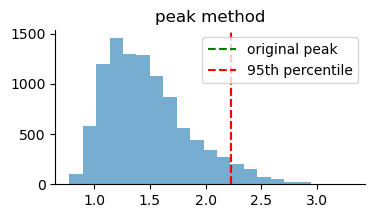

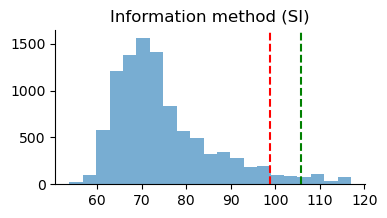

In [6]:
from placefield_detection.alternative_detection_methods import (
    peak_method,
    information_method,
)

neuron = 11
neuron_activity = ld["S"][:, behavior["active"]]
shuffles = 10000
is_pc, p_val = peak_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
is_pc, p_val_info = information_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
print(p_val, p_val_info)

In [7]:
from placefield_detection.alternative_detection_methods import (
    peak_method_batch,
    information_method_batch,
    # stability_method,
)

print(neuron_activity.shape)
# information_method(
#     behavior,
#     neuron_activity[0, :],
#     n_shuffles=10000,
#     plot=True,
# )

# results_info = information_method_batch(
#     behavior,
#     neuron_activity,
#     n_shuffles=10000,
# )
is_place_cell, p_value = peak_method_batch(
    behavior,
    neuron_activity,
    n_shuffles=10000,
)
# stability_method(
#     behavior,
#     neuron_activity,
#     neurons,
#     nbin,
# )

(848, 2855)


100%|██████████| 848/848 [00:51<00:00, 16.53it/s]


TypeError: list indices must be integers or slices, not str

In [ ]:
from placefield_detection.utils import (
    get_firingmap,
    obtain_significant_events_from_one_sided_process,
)

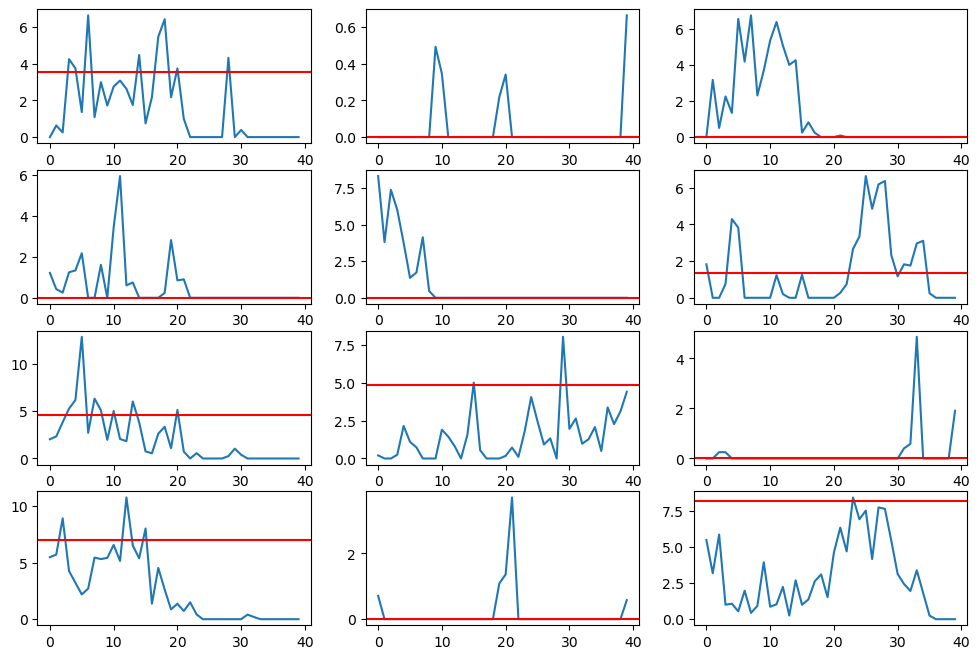

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(12, 8))

for neuron in range(12):

    activity = prepare_activity(
        neuron_activity[neuron, :], behavior, f=f, only_active=only_active
    )

    fmap = get_firingmap(
        activity["spikes"],
        behavior["position"],
        behavior["dwelltime"],
        nbin=behavior["nbin"],
    )
    # frate, threshold, _ = get_firingrate(neuron_activity[0,:],IQR=True)
    field, threshold, sd_r = obtain_significant_events_from_one_sided_process(
        fmap, baseline_mode="percentile", sd_mode="iqr", prctile=50
    )
    # print("sd_r:", sd_r)
    # baseline_prc, sd = estimate_stats_from_one_sided_process(fmap, "percentile", "iqr")
    # print("\n")
    # frate, threshold, PF = get_firingrate(fmap, sd_r=-1, IQR=False)
    # frate, threshold_IQR, PF = get_firingrate(fmap, sd_r=-1, IQR=True)

    ax = axes[neuron // 3, neuron % 3]
    ax.plot(fmap, label="firing map")
    ax.axhline(threshold, color="r", linestyle="-", label="threshold")
    # ax.axhline(baseline_prc, color="g", linestyle="-", label="baseline %")
    # ax.axhline(threshold + 2 * sd, color="r", linestyle="--", label="threshold SD")
    # ax.axhline(
    # baseline_prc + 2 * sd_iqr, color="g", linestyle="--", label="threshold SD"
    # )
    # ax.set_title(f"Neuron {neuron}")
    # print(threshold, "vs", threshold_IQR)
    # print(PF)

[[0.         0.         0.         ... 0.         0.04293704 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02147177 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[       nan        nan        nan ...        nan 0.04293704        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan 0.02147177        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


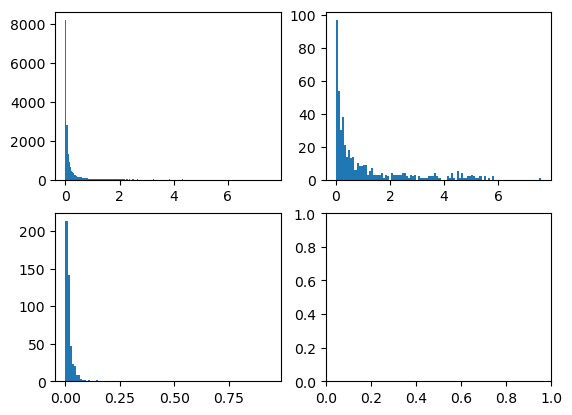

In [49]:
# activity =
import numpy as np

act_masked = np.ma.masked_array(neuron_activity, mask=neuron_activity == 0)
act_masked = np.ma.filled(act_masked, np.nan)
print(neuron_activity)
print(act_masked)
fig, axes = plt.subplots(2, 2)
axes[0][0].hist(neuron_activity[neuron_activity > 0], bins=200)
axes[0][1].hist(np.nanmax(act_masked, axis=1), bins=100)
axes[1][0].hist(np.nanpercentile(act_masked, 20, axis=1), bins=100)
plt.show()

# test namras method

In [9]:
from placefield_detection.alternative_detection_methods.thresholding_pf_method import (
    thresholding_method_single,
    thresholding_method_batch,
)


# print(neuron_activity.shape)
# results = thresholding_method_single(behavior, ld["S"][3, :], plot=True)
results = thresholding_method_single(behavior, neuron_activity[11, :], plot=True)
results
# place_fields = thresholding_method_batch(behavior, neuron_activity, sigma=2)

NameError: name 'neuron_activity' is not defined

In [ ]:
behavior["dwelltime"].shape

(40,)

{}


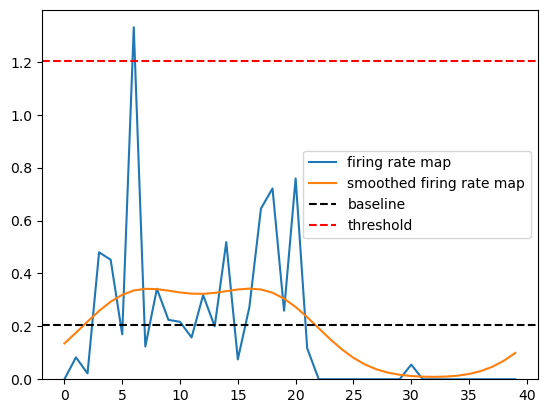

In [118]:
for neuron in range(1):
    field = thresholding_method_single(
        behavior, neuron_activity[neuron, :], threshold_factor=4, sigma=4, plot=True
    )
    print(field)
# field = thresholding_method_single(
#     behavior, neuron_activity[4, :], sigma=2, plot=True
# )
# field